## Import Template

In [6]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

df = pd.read_csv("9_Customer_churn.csv")
df.sample(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4004,5803-NQJZO,Male,0,Yes,No,72,Yes,Yes,DSL,Yes,...,Yes,Yes,No,No,Two year,Yes,Bank transfer (automatic),67.80,4804.65,No
159,7554-NEWDD,Male,0,No,No,10,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.70,251.6,No
1105,7363-QTBIW,Female,0,Yes,No,9,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,79.75,769.1,No
4046,0440-QEXBZ,Female,0,No,No,44,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,50.15,2139.1,No
1529,9764-REAFF,Female,0,Yes,No,59,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),18.40,1057.85,No


## Data Cleaning Phase

In [7]:
df.drop("customerID", axis="columns", inplace = True)
df.dtypes # we want to convert total charges to float as well

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
df.TotalCharges.values
print(df.TotalCharges.dtype)
pd.to_numeric(df.TotalCharges, errors="coerce") # ignore character with spaces

object


0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [9]:
# rows without total charges
df[pd.to_numeric(df.TotalCharges, errors="coerce").isnull()]

# drop them since it's a small size in the sample
df1 = df[df.TotalCharges != " "]
# df1.shape

In [10]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)
df1.TotalCharges.dtype

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


dtype('float64')

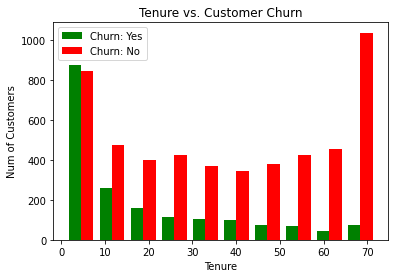

In [11]:
# Get a good visual about tenure vs Churn
tenure_churn_no = df1[df1.Churn == "No"].tenure
tenure_churn_yes = df1[df1.Churn == "Yes"].tenure

plt.xlabel("Tenure")
plt.ylabel("Num of Customers")
plt.title("Tenure vs. Customer Churn")
plt.hist([tenure_churn_yes, tenure_churn_no], color=["green", "red"], label=["Churn: Yes", "Churn: No"])
plt.legend()

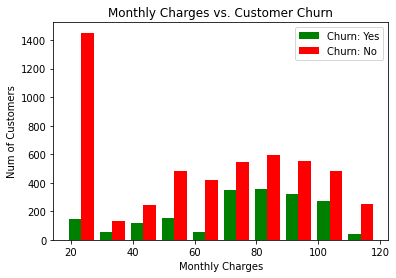

In [12]:
# Get another good visual about Monthly Charges vs Churn
mc_churn_no = df1[df1.Churn == "No"].MonthlyCharges
mc_churn_yes = df1[df1.Churn == "Yes"].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Num of Customers")
plt.title("Monthly Charges vs. Customer Churn")
plt.hist([mc_churn_yes, mc_churn_no], color=["green", "red"], label=["Churn: Yes", "Churn: No"])
plt.legend()

In [13]:
# List out unique values in each column
def print_uni_col(df):
    for col in df:
        # if df1[col].dtype == "object":
        print(f"{col}: {df[col].unique()}")

# remove redundant param (cvt to no)
df1.replace("No internet service", "No", inplace=True) # inplace will modify the original data instead of return a copy
df1.replace("No phone service", "No", inplace=True)
df1["gender"].replace({"Female": 1, "Male": 0}, inplace=True)

# cvt yes/no to 1/0
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [14]:
# Applying One hot encoding for categorical columns (created 7 more columns)
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.dtypes # all numbers no objects

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [15]:
# Scaling values that over 0-1 range
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']
scaler = MinMaxScaler()

df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])
print_uni_col(df2) # successfully scaled

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

## Create data sets and Model

In [16]:
# split train and test sets
X = df2.drop("Churn", axis="columns")
y = df2["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

X_train.shape

(5625, 26)

In [17]:
model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26, ), activation="relu"), # Input Layer / hidden layer
    # keras.layers.Dense(50, activation="relu"),
    # keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid") # Output layer
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

## Train the model

In [18]:
# First run 5 epochs and make sure accuracy is increasing
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 1s 1ms/step - loss: 0.5142 - accuracy: 0.7460
Epoch 2/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.7968
Epoch 3/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4204 - accuracy: 0.7982
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.8028
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4150 - accuracy: 0.8039
Epoch 6/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4137 - accuracy: 0.8050
Epoch 7/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4120 - accuracy: 0.8057
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.8060
Epoch 9/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8050
Epoch 10/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4091 - accura

## Test and Visulize the results

In [19]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 978us/step - loss: 0.4538 - accuracy: 0.7775


[0.45384183526039124, 0.7775408625602722]

In [20]:
yp = model.predict(X_test)
yp[yp > 0.5] = 1
yp[yp <= 0.5] = 0

# print prediction and actual side by side
np.c_[yp[:10], y_test[:10]]

array([[0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [21]:
# cm & reports
print(classification_report(y_test, yp))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       999
           1       0.66      0.48      0.56       408

    accuracy                           0.78      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



Text(69.0, 0.5, 'Actual')

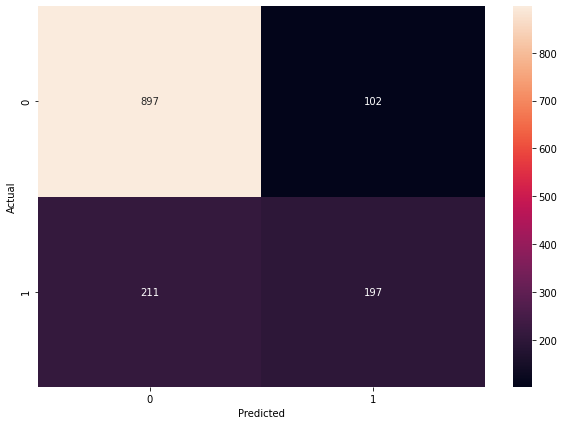

In [22]:
# plot it

cm = tf.math.confusion_matrix(labels=y_test, predictions=yp)

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")